In [16]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pyproj

In [17]:
# # gw50m
# answer_location = (52.53962045830213, 13.419884901364885, 50)
# source_locations = [(52.542509627168, 13.42523777393717, 23), (52.538449358627645, 13.417154706545864, 23), (52.54124707715658, 13.42007143605056, 23), (52.53863682156572, 13.423243543905807, 5.1), (52.54022829654233, 13.424028618727982, 23), (52.53768690920158, 13.423827698593255, 19), (52.53701243697258, 13.41926365424317, 23), (52.53765506974833, 13.416535624425991, 23), (52.540951204354315, 13.414768595630743, 19), (52.53846109447526, 13.42080118586715, 23)]
# rssi = np.array([-73.54774707124031, -67.2598116355535, -65.27220428570674, -74.73454353002585, -68.84323573826707, -70.71299630957999, -69.14659573310989, -69.70525715798875, -74.09346777134436, -63.18224654815296])
# d = []
# # rssi to distance with curve fit
# for i in range(len(rssi)):
#     d.append(10**((-18.67881 - rssi[i]) / (10 * 2.04002)))
# print(d)

# gw100m
answer_location = (52.53962045830213, 13.419884901364885, 100)
source_locations = [(52.542509627168, 13.42523777393717, 23), (52.538449358627645, 13.417154706545864, 23), (52.54124707715658, 13.42007143605056, 23), (52.53863682156572, 13.423243543905807, 5.1), (52.54022829654233, 13.424028618727982, 23), (52.53768690920158, 13.423827698593255, 19), (52.53701243697258, 13.41926365424317, 23), (52.53765506974833, 13.416535624425991, 23), (52.540951204354315, 13.414768595630743, 19), (52.53846109447526, 13.42080118586715, 23)]
rssi = np.array([-73.94630524200359, -67.04524365136507, -65.51133843649966, -71.99102431036357, -69.38046352414914, -70.69053819851595, -69.09353142802274, -69.9814290434943, -71.63403554811134, -63.81425676768592])
d = []
for i in range(len(rssi)):
    d.append(10**((-18.67881 - rssi[i]) / (10 * 2.04002)))
print(d)

# # gw100m_nobuilding
# answer_location = (52.53962045830213, 13.419884901364885, 200)
# source_locations = [(52.542509627168, 13.42523777393717, 23), (52.538449358627645, 13.417154706545864, 23), (52.54124707715658, 13.42007143605056, 23), (52.53863682156572, 13.423243543905807, 5.1), (52.54022829654233, 13.424028618727982, 23), (52.53768690920158, 13.423827698593255, 19), (52.53701243697258, 13.41926365424317, 23), (52.53765506974833, 13.416535624425991, 23), (52.540951204354315, 13.414768595630743, 19), (52.53846109447526, 13.42080118586715, 23)]
# rssi = np.array([-73.58976692127023, -66.84978429622258, -65.43775615882458, -68.51723739248007, -69.34638664552159, -70.67158737502467, -69.47921756875596, -69.74188545126589, -71.33057463016215, -63.86118311152556])
# d = []
# for i in range(len(rssi)):
#     d.append(10**((-18.67881 - rssi[i]) / (10 * 2.04002)))
# print(d)

[511.8755465287958, 234.89856649485617, 197.5557485663918, 410.50477950801775, 305.73897592295174, 354.46186954189903, 295.9958660450461, 327.19722509936946, 394.29288508294167, 163.11736949587115]


[[ 393206.92929944 5822545.57797782]
 [ 392648.90380971 5822105.97886155]
 [ 392853.52073335 5822412.81237481]
 [ 393062.2869512  5822117.78918582]
 [ 393119.39393133 5822293.63344594]
 [ 393099.59493713 5822011.27248963]
 [ 392788.42587066 5821943.02651801]
 [ 392604.98099848 5822018.55750819]
 [ 392493.19731635 5822387.79122519]
 [ 392896.22615985 5822101.86626953]]
[ 596768.90198158 4433720.53683546]
[100.68520710896857, 67.80834262756409, 62.05735227455193, 90.0560691467285, 77.55500962838595, 83.60165901965092, 76.28838260771381, 80.27418328446198, 88.23750734046618, 56.23475251050212]
Receiver location: [52.539364607663245, 13.42038944583609]
error to the truth 44.51335406954184
[379.48598282 174.08627969 148.47302742 119.79291863 187.33556428
 215.11290163 196.30327073 243.00443282 331.90418136  48.08809662]


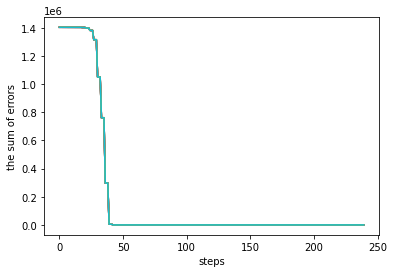

In [18]:
# multilateration program

errors_array = []

R = 6371000 # radius of the earth in meters

# GPS coordinates of the sources
# source_locations = [
#     (46.048174, 11.134445, 0),  # Source 1
#     (46.048275, 11.134562, 0),  # Source 2
#     (46.048389, 11.134393, 0),  # Source 3
#     (46.048431, 11.134557, 0)  # Source 4
# ]

altitude = 10
zone = int((source_locations[0][1] + 180) / 6) + 1

# Distances from the receiver to the sources
# d = np.array([7.5, 7.2, 9.8, 9.4])

# Convert GPS coordinates to Cartesian coordinates
# def to_cartesian(lat, lon, alt):
#     x, y, z = pyproj.Transformer.from_crs(4979, 4978, always_xy=True).transform(lon, lat, alt)
#     return x, y, z

def to_cartesian(lat, lon):
    # Calculate UTM zone from longitude
    zone = int((lon + 180) / 6) + 1
    # Determine if the point is in the Northern or Southern hemisphere
    hemisphere = 'north' if lat >= 0 else 'south'

    # define the coordinate systems
    transformer = pyproj.Transformer.from_crs("epsg:4326", f"epsg:326{zone if lat >= 0 else zone + 100}")

    x, y = transformer.transform(lat, lon)
    return x, y

# Convert Cartesian coordinates to GPS coordinates
# def to_gps(x, y, z):
#     lon, lat, alt = pyproj.Transformer.from_crs(4978,4979, always_xy=True).transform(x, y, z)
#     return lat, lon, alt

def to_gps(x, y, zone, hemisphere):
    # define the coordinate systems
    transformer = pyproj.Transformer.from_crs(f"epsg:326{zone if hemisphere == 'north' else zone + 100}", "epsg:4326")
    
    lat, lon = transformer.transform(x, y)
    return [lat, lon]

# Calculate the distance between the receiver and each source
def distance(xy_receiver, xy_source):
    return np.linalg.norm(xy_source - xy_receiver)

# Objective function to minimize the sum of squared errors between estimated and actual distances
def error(xy_receiver, xy_sources, d):
    distances = np.linalg.norm(xy_sources - xy_receiver, axis=1)
    errors = distances - d
    errors_array.append(np.sqrt(errors**2))
    return np.sum(errors**2)

# Define a function to convert radians to degrees
def degrees(rad):
    return rad * 180 / np.pi

# Starting GPS coordinates of the receiver (can be anywhere)
receiver_location = (40.048174, 10.134445, 0)

# Convert the GPS coordinates of the sources and the receiver to Cartesian coordinates
xy_sources = np.array([to_cartesian(lon, lat) for lon, lat, _ in source_locations])
xy_receiver = np.array(to_cartesian(*receiver_location[:2]))

print(xy_sources)
print(xy_receiver)

# Calculate the distance in 2d plane at the altitude
d_2d = []
for i in range(len(d)):
    alt_diff = np.abs(altitude - d[i])
    distance_2d = np.sqrt(d[i]**2-alt_diff**2)
    d_2d.append(distance_2d)
print(d_2d)

# Perform multilateration to estimate the location of the receiver
result = minimize(error, xy_receiver, args=(xy_sources, d_2d))
xy_receiver_estimated = result.x

# Convert the estimated Cartesian coordinates of the receiver back to GPS coordinates
receiver_location_estimated = to_gps(*xy_receiver_estimated, zone, 'north')

print('Receiver location:', receiver_location_estimated)
print('error to the truth', np.linalg.norm(to_cartesian(*answer_location[:2])-xy_receiver_estimated))

# # Plot the sources and the estimated location of the receiver
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# # Plot the sources
# for i in range(len(source_locations)):
#     x, y, z = to_cartesian(*source_locations[i])
#     ax.scatter(x, y, z, color='r', marker='^')

# # Plot the estimated location of the receiver
# x, y, z = to_cartesian(*receiver_location_estimated)
# ax.scatter(x, y, z, color='b', marker='o')

# # Set the labels and title
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# ax.set_title('Multilateration')

# print(source_locations)
# # Plot circles (or spheres) representing the distance from each source
# for i in range(len(source_locations)):
#     # Calculate the radius of the circle (or sphere) in meters
#     radius = d[i]
#     # Get the Cartesian coordinates of the source
#     x, y, z = to_cartesian(*source_locations[i])
#     # Create a grid of points on the surface of the sphere
#     # Sphere in 3D
#     u = np.linspace(0, 2*np.pi, 100)
#     v = np.linspace(0, np.pi, 100)
#     X = x + radius*np.outer(np.cos(u), np.sin(v))
#     Y = y + radius*np.outer(np.sin(u), np.sin(v))
#     Z = z + radius*np.outer(np.ones_like(u), np.cos(v))
#     ax.plot_surface(X, Y, Z, color='r', alpha=0.2)

# plt.show()

# create a figure for error
fig = plt.figure()

plt.plot(errors_array)
plt.xlabel("steps")
plt.ylabel("the sum of errors")
print(errors_array[-1])

# show the plot
plt.show()

import folium

# Plot the sources and the estimated location of the receiver on a 2D map
m = folium.Map(location=receiver_location_estimated[:2], zoom_start=18, max_zoom=20)

# Plot the sources
for i in range(len(source_locations)):
    folium.Marker(location=source_locations[i][:2]).add_to(m)

# Plot the estimated location of the receiver
folium.Marker(location=receiver_location_estimated[:2], icon=folium.Icon(color='purple')).add_to(m)

# answer
folium.Marker(location=answer_location[:2], icon=folium.Icon(color='green')).add_to(m)

# Plot circles representing the distance from each source
for i in range(len(source_locations)):
    # Calculate the radius of the circle in meters
    radius = d[i]
    # Get the location of the source
    source_location = source_locations[i][:2]
    # Draw the circle on the map
    folium.Circle(location=source_location, radius=radius, color='red', fill=False).add_to(m)

m



In [19]:
# create every pattern of 4 or more beacons
import itertools

source_locations_iter = []
d_iter = []
for n in range(3,len(source_locations)+1):
	for source_location in itertools.combinations(source_locations, n):
	    source_locations_iter.append(list(source_location))
	    
for n in range(3,len(d_2d)+1):
	for d_i in itertools.combinations(d_2d, n):
	    d_iter.append(list(d_i))
print(source_locations_iter)
print(d_iter)

[[(52.542509627168, 13.42523777393717, 23), (52.538449358627645, 13.417154706545864, 23), (52.54124707715658, 13.42007143605056, 23)], [(52.542509627168, 13.42523777393717, 23), (52.538449358627645, 13.417154706545864, 23), (52.53863682156572, 13.423243543905807, 5.1)], [(52.542509627168, 13.42523777393717, 23), (52.538449358627645, 13.417154706545864, 23), (52.54022829654233, 13.424028618727982, 23)], [(52.542509627168, 13.42523777393717, 23), (52.538449358627645, 13.417154706545864, 23), (52.53768690920158, 13.423827698593255, 19)], [(52.542509627168, 13.42523777393717, 23), (52.538449358627645, 13.417154706545864, 23), (52.53701243697258, 13.41926365424317, 23)], [(52.542509627168, 13.42523777393717, 23), (52.538449358627645, 13.417154706545864, 23), (52.53765506974833, 13.416535624425991, 23)], [(52.542509627168, 13.42523777393717, 23), (52.538449358627645, 13.417154706545864, 23), (52.540951204354315, 13.414768595630743, 19)], [(52.542509627168, 13.42523777393717, 23), (52.5384493

[[191.72195447975932, 120.86073287895985, 3, 112.91019842696032], [215.79848910544902, 120.2411921187943, 3, 85.53545226685263], [208.96556701648163, 144.264940468027, 3, 93.50666388363759], [246.2736584417655, 135.50351925956068, 3, 57.4489865146943], [253.92541556630275, 57.58367416528763, 3, 78.5870694649202], [258.3292128064014, 4.440232859040998, 3, 96.23039399260607], [262.0567910716108, 123.1414860239543, 3, 67.68424114095546], [216.11754244512113, 82.45939227161583, 3, 86.75829051282523], [144.30583309462693, 234.2048734098744, 3, 12.173560770276362], [101.45753687621605, 276.5352821673906, 3, 22.21924000806721], [186.63267035321311, 226.3879101777663, 3, 27.573808029369857], [222.11865359234653, 123.26123737382889, 3, 87.78962955567997], [224.07137700644543, 87.88936057781204, 3, 122.76548788466668], [182.4186638675782, 236.68229885756514, 3, 125.32649134436984], [162.95600030561081, 182.47385702333852, 3, 51.67392649988056], [96.24488867162324, 320.7982566040351, 3, 49.655627

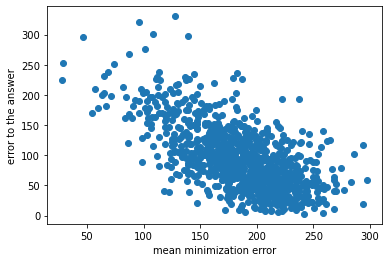

In [20]:
# multilateration with every patterns

errors_array = []

R = 6371000 # radius of the earth in meters

# GPS coordinates of the sources
# source_locations = [
#     (46.048174, 11.134445, 0),  # Source 1
#     (46.048275, 11.134562, 0),  # Source 2
#     (46.048389, 11.134393, 0),  # Source 3
#     (46.048431, 11.134557, 0)  # Source 4
# ]

altitude = 10
zone = int((source_locations[0][1] + 180) / 6) + 1

# Distances from the receiver to the sources
# d = np.array([7.5, 7.2, 9.8, 9.4])

# Convert GPS coordinates to Cartesian coordinates
# def to_cartesian(lat, lon, alt):
#     x, y, z = pyproj.Transformer.from_crs(4979, 4978, always_xy=True).transform(lon, lat, alt)
#     return x, y, z

def to_cartesian(lat, lon):
    # Calculate UTM zone from longitude
    zone = int((lon + 180) / 6) + 1
    # Determine if the point is in the Northern or Southern hemisphere
    hemisphere = 'north' if lat >= 0 else 'south'

    # define the coordinate systems
    transformer = pyproj.Transformer.from_crs("epsg:4326", f"epsg:326{zone if lat >= 0 else zone + 100}")

    x, y = transformer.transform(lat, lon)
    return x, y

# Convert Cartesian coordinates to GPS coordinates
# def to_gps(x, y, z):
#     lon, lat, alt = pyproj.Transformer.from_crs(4978,4979, always_xy=True).transform(x, y, z)
#     return lat, lon, alt

def to_gps(x, y, zone, hemisphere):
    # define the coordinate systems
    transformer = pyproj.Transformer.from_crs(f"epsg:326{zone if hemisphere == 'north' else zone + 100}", "epsg:4326")
    
    lat, lon = transformer.transform(x, y)
    return [lat, lon]

# Calculate the distance between the receiver and each source
def distance(xy_receiver, xy_source):
    return np.linalg.norm(xy_source - xy_receiver)

# Objective function to minimize the sum of squared errors between estimated and actual distances
def error(xy_receiver, xy_sources, d):
    distances = np.linalg.norm(xy_sources - xy_receiver, axis=1)
    errors = distances - d
    errors_array.append(np.sqrt(errors**2))
    return np.sum(errors**2)

# Define a function to convert radians to degrees
def degrees(rad):
    return rad * 180 / np.pi

xy_receiver_estimated_list = []
receiver_locations_estimated = []
error_answer_minimization = []

for i in range(len(d_iter)):

    source_locations = source_locations_iter[i]
    distance = d_iter[i]

    # Starting GPS coordinates of the receiver (can be anywhere)
    receiver_location = (40.048174, 10.134445, 0)

    # Convert the GPS coordinates of the sources and the receiver to Cartesian coordinates
    xy_sources = np.array([to_cartesian(lon, lat) for lon, lat, _ in source_locations])
    xy_receiver = np.array(to_cartesian(*receiver_location[:2]))

    # Perform multilateration to estimate the location of the receiver
    result = minimize(error, xy_receiver, args=(xy_sources, distance))
    xy_receiver_estimated = result.x
    xy_receiver_estimated_list.append(xy_receiver_estimated)

    error_answer = np.linalg.norm(to_cartesian(*answer_location[:2])-xy_receiver_estimated)
    error_answer_minimization.append([np.mean(errors_array[-1]), error_answer, len(distance), np.std(errors_array[-1])])

    # Convert the estimated Cartesian coordinates of the receiver back to GPS coordinates
    receiver_location_estimated = to_gps(*xy_receiver_estimated, zone, 'north')
    receiver_locations_estimated.append(receiver_location_estimated)

    # print('Receiver location:', xyz_receiver_estimated)
    # print('Receiver location:', receiver_location_estimated)
    # print('error', np.sum(errors_array[-1]))

print(error_answer_minimization)
error_answer_minimization.sort(key=lambda item: item[0])
plt.scatter([item[0] for item in error_answer_minimization], [item[1] for item in error_answer_minimization])
plt.xlabel("mean minimization error")
plt.ylabel("error to the answer")
plt.show()

import folium

# Plot the sources and the estimated location of the receiver on a 2D map
m = folium.Map(location=receiver_location_estimated[:2], zoom_start=18, max_zoom=20)

# Plot the sources
for i in range(len(source_locations)):
    folium.Marker(location=source_locations[i][:2]).add_to(m)

for i in range(len(receiver_locations_estimated)):
# Plot the estimated location of the receiver
    folium.Marker(location=receiver_locations_estimated[i][:2], icon=folium.Icon(color='purple'), tooltip=f'Point {i}').add_to(m)

# answer
folium.Marker(location=answer_location[:2], icon=folium.Icon(color='green')).add_to(m)

# Plot circles representing the distance from each source
for i in range(len(source_locations)):
    # Calculate the radius of the circle in meters
    radius = d[i]
    # Get the location of the source
    source_location = source_locations[i][:2]
    # Draw the circle on the map
    folium.Circle(location=source_location, radius=radius, color='red', fill=False).add_to(m)

m



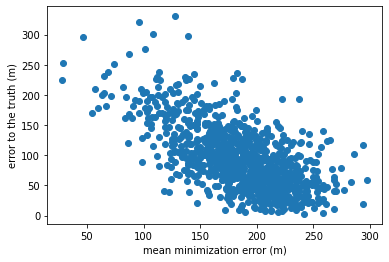

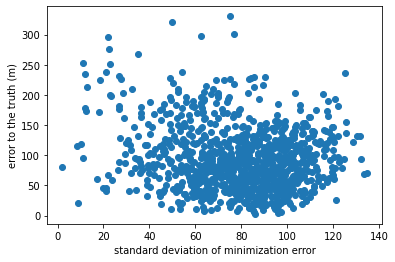

[]
[[199.89094334183534, 230.60390900735865, 197.57939251765745, 161.7102215518448, 167.73907264723377, 181.5938760963215, 191.05772748942027, 209.95951199185495, 128.9147563135096, 202.70806136654465, 178.99681509725664, 132.6674207676798, 172.25317746764264, 178.5998818068075, 196.21919396996924, 151.36942442848232, 196.18679294406408, 301.5975368861206, 226.43888407903933, 99.02398922356792, 200.35347711054425, 213.83982578436158, 237.4891431068459, 82.45947100835367, 170.18709542299027, 188.78794051585356, 180.00637923152846, 84.38171698309374, 146.63357509920812, 39.296804598399746, 209.51296788935122, 94.48540943206395, 127.51731209760864, 105.92852026012375, 135.67303369899227, 106.71420651390632, 146.4997921777458, 144.4617815231484, 114.48063733542443, 129.77964347328924, 106.9568015216387, 229.06957605998508, 193.3569590570243, 227.94184897245253, 175.46022506419223, 57.08527809536508, 68.07962663450219, 83.03936759565818, 38.281951912653625, 92.514041713144, 225.548493745151

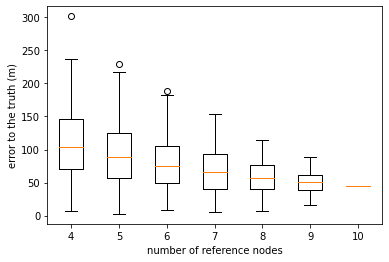

[]
[[63.174337051543574, 65.2292456077958, 71.25594864103252, 83.51316203508198, 87.45083825294084, 91.08948030980093, 92.56597866779357, 97.76079957097446, 98.75618648612229, 99.86587952801759, 101.17345682317936, 102.93797235048385, 103.25891653517544, 104.72066279471188, 105.44511846587685, 106.53741808988572, 107.3416962801814, 108.34459502116582, 110.76058953811622, 112.08619603681649, 112.71634786653476, 112.97086755602041, 113.68498344970656, 113.80871205278697, 116.6656101120598, 119.0644247897838, 120.38087465738188, 120.9924742143806, 122.66553229124091, 122.7058175611273, 123.2139520763966, 123.84864750865597, 125.04563775714297, 126.75390498516359, 126.84321127042662, 127.3452621395643, 130.672767711569, 132.22812928433848, 132.815391844394, 133.33836376503552, 134.22725118662024, 136.17027478497664, 136.25637037096038, 137.06958510554483, 137.2723308238106, 138.5135707661591, 139.51061276763213, 139.61636447447128, 140.19254765371977, 140.50296263359832, 140.5484822690138,

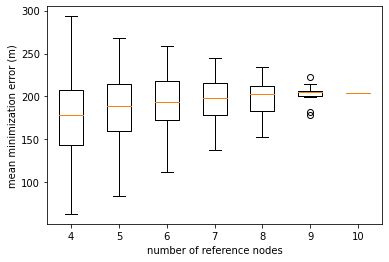

In [21]:
# visualization of multilateration with every pattern
# the relation between error to the truth and mean minimization error, number of reference nodes
error_answer_minimization.sort(key=lambda item: item[0])
plt.figure(facecolor="white")
plt.scatter([item[0] for item in error_answer_minimization], [item[1] for item in error_answer_minimization])
plt.xlabel("mean minimization error (m)")
plt.ylabel("error to the truth (m)")

#find line of best fit
a, b = np.polyfit([item[0] for item in error_answer_minimization], [item[1] for item in error_answer_minimization], 1)

#add line of best fit to plot
# plt.plot(np.array([item[0] for item in error_answer_minimization]), a*np.array([item[0] for item in error_answer_minimization])+b)    
plt.show()

error_answer_minimization.sort(key=lambda item: item[0])
plt.figure(facecolor="white")
plt.scatter([item[3] for item in error_answer_minimization], [item[1] for item in error_answer_minimization])
plt.xlabel("standard deviation of minimization error")
plt.ylabel("error to the truth (m)")

#find line of best fit
a, b = np.polyfit([item[3] for item in error_answer_minimization], [item[1] for item in error_answer_minimization], 1)

#add line of best fit to plot
# plt.plot(np.array([item[0] for item in error_answer_minimization]), a*np.array([item[0] for item in error_answer_minimization])+b)    
plt.show()

plt.figure(facecolor="white")
error_answer_reference_boxplot = [[] for _ in range(20)]
print(error_answer_reference_boxplot[0])

for i in range(len(error_answer_minimization)):
    error_answer_reference_boxplot[error_answer_minimization[i][2]-4].append(error_answer_minimization[i][1])
print(error_answer_reference_boxplot)
plt.boxplot(error_answer_reference_boxplot[:7])
plt.xticks([i for i in range(1,8)],[i for i in range(4,11)])
plt.xlabel("number of reference nodes")
plt.ylabel("error to the truth (m)")
plt.show()

plt.figure(facecolor="white")
error_answer_reference_boxplot = [[] for _ in range(20)]
print(error_answer_reference_boxplot[0])

for i in range(len(error_answer_minimization)):
    error_answer_reference_boxplot[error_answer_minimization[i][2]-4].append(error_answer_minimization[i][0])
print(error_answer_reference_boxplot)
plt.boxplot(error_answer_reference_boxplot[:7])
plt.xticks([i for i in range(1,8)],[i for i in range(4,11)])
plt.xlabel("number of reference nodes")
plt.ylabel("mean minimization error (m)")
plt.show()

In [22]:
# multilateration with provided altitude of the drone
